# Mohamed Benyahia Report 

***1. Autoregressive process***

***1.1 Synthesis:***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy

In [2]:
def generateAR(N,sigma,coeff):
    coeff=[1]+coeff
    Z= np.random.normal(0,sigma,N)
    X=Z
    for t in range(1,N):
        for i in range(1,len(coeff)):
            if t-i>=0:
                X[t]+=coeff[i]*X[t-i]
    return X



***1.2 Non-parametric estimation : periodogram***

2.

In [3]:
def periodogram(X,N_FFT,k,method='standard',L=None,K=None,S=None,w=None):
    """_summary_

    Args:
        X : input signal
        N_FFT : number of FFT points
        k : bin of FFT
        L : number of sub-samples 
        K : parameter of Welch Method
        S : parameter of Welch Method
        w : window of length M
        method (str, optional): either standard or Bartlett or Welch. Defaults to 'standard'.

    Returns:
        S_hat: S_hat(k/N_FFT)
    """
    N=len(X)
    if method=='standard':
    
        dft= np.fft.fft(X,N_FFT)
        S_hat=(np.absolute(dft[k]))**2/N
        
    elif method=='bartlett':
        M=N//L
        X_tilde=np.zeros((L+1,M+1))
        for t in range(1,M+1):
            for i in range(1,L+1):
                    X_tilde[i][t]=X[(i-1)*M+t-1]

        S_hat=0
        for i in range(1,L+1):
             S_hat+=(1/L)*(np.absolute((np.fft.fft(X_tilde[i][1:],N_FFT))[k]))**2/(M)
    else:
        M=N//L
        S_hat=0
        X_tilde_windowed=np.zeros((S+1,M+1))
        for t in range(1,M+1):
            for i in range(1,S+1):
                    X_tilde_windowed[i][t]=X[(i-1)*K+t-1]*w[t-1]
        P=(1/M)*np.linalg.norm(w)**2
        
        for i in range(1,S+1):
             S_hat+=(1/S)*(1/(M*P))*(np.absolute((np.fft.fft(X_tilde_windowed[i][1:],N_FFT))[k]))**2



    return S_hat
        


3.

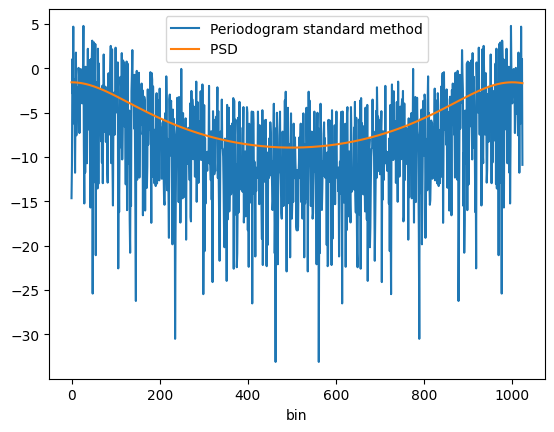

In [4]:
a=0.4
sigma=0.5
N=1000
N_FFT=1024
j=complex(0,1)
def PSD_AR1(k,N,sigma,a):

    return sigma**2/np.absolute(1-a*np.exp(-2*j*np.pi*k/N))**2
X=generateAR(1000,sigma,[a])
bins_std=list(range(N_FFT))


Periodos_std=np.array([periodogram(X,N_FFT,k,'standard') for k in bins_std])

PSD=np.array([PSD_AR1(k,N,sigma,a) for k in bins_std])
plt.xlabel("bin")
plt.plot(bins_std,10*np.log10(Periodos_std),label="Periodogram standard method")

plt.plot(bins_std,10*np.log10(PSD),label="PSD ")
plt.legend()
plt.show()


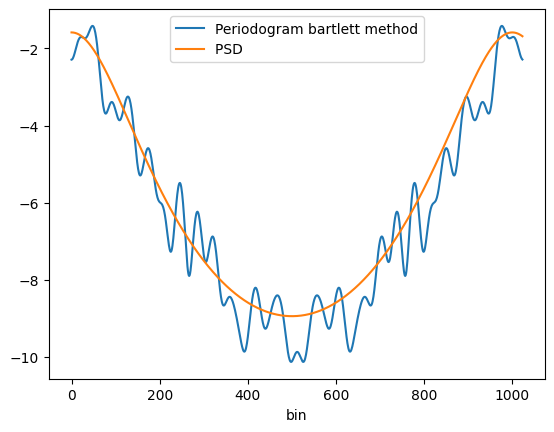

In [5]:
L=int(np.sqrt(N))

Periodos_bartlett=np.array([periodogram(X,N_FFT,k,'bartlett',L) for k in bins_std])

PSD=np.array([PSD_AR1(k,N,sigma,a) for k in bins_std])
plt.xlabel("bin")
plt.plot(bins_std,10*np.log10(Periodos_bartlett),label="Periodogram bartlett method")

plt.plot(bins_std,10*np.log10(PSD),label="PSD ")
plt.legend()
plt.show()

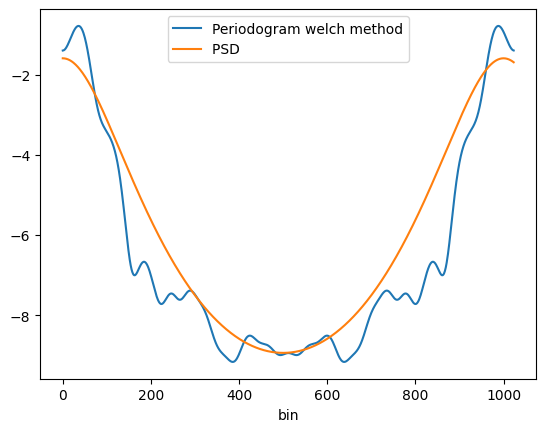

In [6]:
L=int(np.sqrt(N))
M=N//L
K=M
S=N//M
w=np.hamming(M)

Periodos_welch=np.array([periodogram(X,N_FFT,k,method='welch',L=L,K=K,S=S,w=w) for k in bins_std])


plt.xlabel("bin")
plt.plot(bins_std,10*np.log10(Periodos_welch),label="Periodogram welch method")

plt.plot(bins_std,10*np.log10(PSD),label="PSD ")
plt.legend()
plt.show()

4. 
In terms of bias, we can see that these three estimators satisfy the asymptotic unbiasedness.  
In terms of variance, for the standard estimator, we can see that there is still a lot of noise.   
After using the Bartlett estimator , we can see that the variance has been reduced.  
With the Welch method, the variance has been reduced further. 


***1.3 Parametric estimation : linear prediction***

5.

In [7]:

def empiricalAutoCov(X,k):
    n=len(X)
 
    s=0
    for t in range(0,n-np.abs(k)):
        if t+k<n and t+k>=0:
          s=s+X[t+np.abs(k)]*X[t]
    if k>=0:
        return s/n
    else :
        return np.conjugate(s)/n


   

def generateGamma(X,p):
    gamma = np.zeros((p+1,p+1))
    for i in range(p+1):
        for j in range(p+1):
            gamma[i][j]=empiricalAutoCov(X,np.abs(i-j))
    return gamma

gamma=generateGamma(X,1)
result =np.matmul(np.linalg.inv(gamma),np.transpose(np.array([1,0])))
variance= 1/result[0]
result = result*variance
result = result*(-1)
sigma_estimated=np.sqrt(variance)
coeff_estimated=result[1]
print("sigma estimated = ",sigma_estimated)
print("sigma axact = ",sigma)
print("coefficient estimated = ",coeff_estimated)
print("coefficient exact = ",a)


sigma estimated =  0.4845762653168486
sigma axact =  0.5
coefficient estimated =  0.4280229912205072
coefficient exact =  0.4


6.

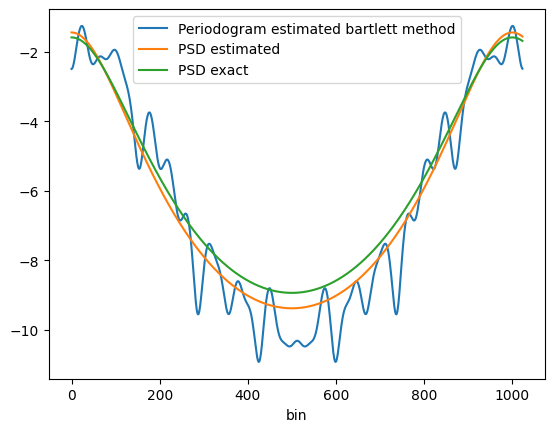

In [8]:
L=int(np.sqrt(1000))
N_FFT=1024
X_estim=generateAR(1000,sigma_estimated,[coeff_estimated])
PSD=np.array([PSD_AR1(k,N,sigma,a) for k in bins_std])
Periodos_estim=np.array([periodogram(X_estim,N_FFT,k,'bartlett',L=L) for k in bins_std])
PSD_estimated=np.array([PSD_AR1(k,N,sigma_estimated,coeff_estimated) for k in bins_std])
plt.xlabel("bin")

plt.plot(bins_std,10*np.log10(Periodos_estim),label="Periodogram estimated bartlett method")
plt.plot(bins_std,10*np.log10(PSD_estimated),label="PSD estimated ")
plt.plot(bins_std,10*np.log10(PSD),label="PSD exact ")
plt.legend()
plt.show()

We can see that in average the periodogram and the PSD of the estimated AR model and the PSD of the exact AR model are the same.

***1.4 Application to speech signals***

7.

In [9]:

x= librosa.load('sounds//aeiou.wav',sr=8000)[0]


Text(0, 0.5, 'Audio')

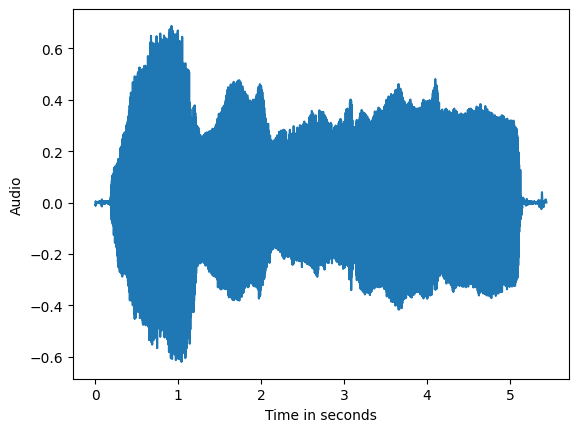

In [10]:
sample_time = np.linspace(0, len(x)/8000, len(x))
plt.plot(sample_time,x)
plt.xlabel('Time in seconds')
plt.ylabel('Audio')

In [11]:
def theoreticalSpecPower(N_FFT,k,AR_coeff,sigma):
   AR_coeff=[1]+AR_coeff
   denom=1
   j=complex(0,1)
   for n in range(1,len(AR_coeff)):
      denom-=AR_coeff[n]*np.exp(-2*j*np.pi*(k/N_FFT)*n)
   denom=np.absolute(denom)**2
   specPower=sigma**2/denom
    
    
   return specPower

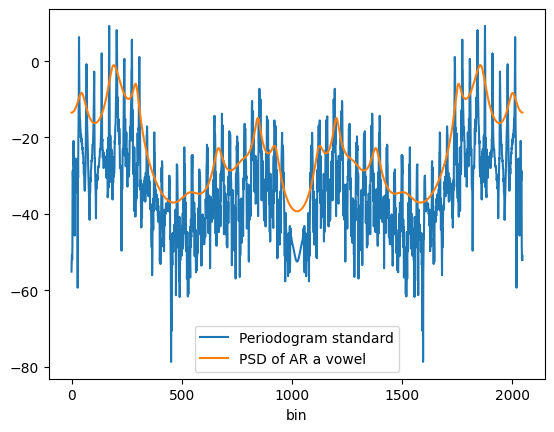

In [12]:
p=20
N_FFT=2048
start=5000
stop=start+2000
a=x[start:stop]
bins=list(range(N_FFT))

gamma_a=generateGamma(a,p)
result_a =np.matmul(np.linalg.inv(gamma_a),np.transpose(np.array([1]+[0]*p)))
var_a= 1/result_a[0]
result_a = result_a*var_a*(-1)
result_a=[round(r,2) for r in result_a]


periodos_a=np.array([periodogram(a,N_FFT,k,'standard') for k in bins])



PSD_AR_a=np.array([theoreticalSpecPower(N_FFT,k,result_a[1:],np.sqrt(var_a)) for k in bins])



plt.plot(bins,10*np.log10(periodos_a),label='Periodogram standard')
plt.plot(bins,10*np.log10(PSD_AR_a),label='PSD of AR a vowel')
plt.xlabel('bin')
plt.legend()
plt.show()


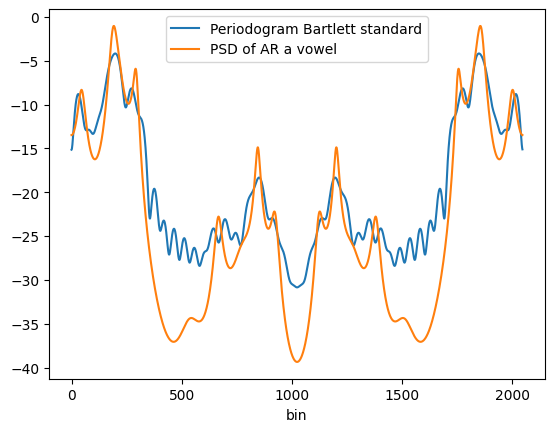

In [13]:
L=int(np.sqrt(len(a)))

periodos_a=np.array([periodogram(a,N_FFT,k,'bartlett',L=L) for k in bins])


plt.plot(bins,10*np.log10(periodos_a),label='Periodogram Bartlett standard')
plt.plot(bins,10*np.log10(PSD_AR_a),label='PSD of AR a vowel')
plt.xlabel('bin')
plt.legend()
plt.show()

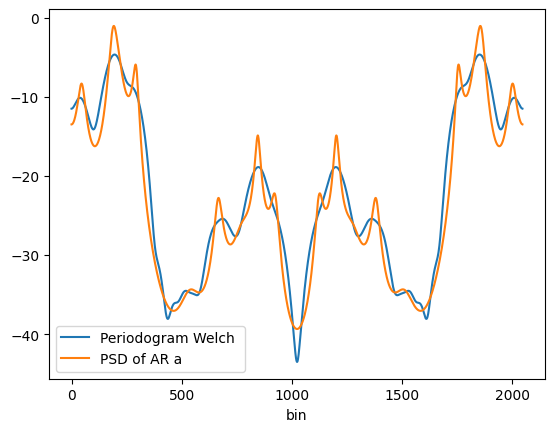

In [14]:
N_a=len(a)
L=int(np.sqrt(N_a))
M=N_a//L
K=M
S=N_a//M
w=np.hamming(M)

periodos_a=np.array([periodogram(a,N_FFT,k,'welch',L=L,K=K,S=S,w=w) for k in bins])



plt.plot(bins,10*np.log10(periodos_a),label='Periodogram Welch ')
plt.plot(bins,10*np.log10(PSD_AR_a),label='PSD of AR a')
plt.xlabel('bin')
plt.legend()
plt.show()

We can see that the PSD of the estimated AR model and the periodogram of the vowel 'a' sound are nearly the same especially after using Welch Method because there is less noise. 

***2. Sum of noisy sinusoids***

***2.1 Synthesis***

1.

In [15]:
def generateSumOfNoisySinusoids(K,freq,Amp,phi0,sigma,sampling_rate,duration):
    """generates the sum of K sinusoids and a gauusian white noise.

    Args:
        K (int): Number of sinusoids
        freq (list): List of frequencies 
        Amp (list): List of Amplitudes
        phi0 (list): List of Origin Phases
        sigma (int): Standard deviation of the noise
        sampling_rate (int): sampling rate in Hz
        duration (int): time duration in seconds
    """
    N_samples=int(duration*sampling_rate)
    T=np.linspace(0,N_samples/sampling_rate,N_samples)
    Z=np.random.normal(0,sigma,N_samples)
    sinusoids=np.array([Amp[i]*np.sin(2*np.pi*freq[i]*T+phi0[i]) for i in range(K)])
    signal=Z+np.sum(sinusoids,axis=0)
    return [T,signal]



***2.2 Non parametric estimation : periodogram***

2.

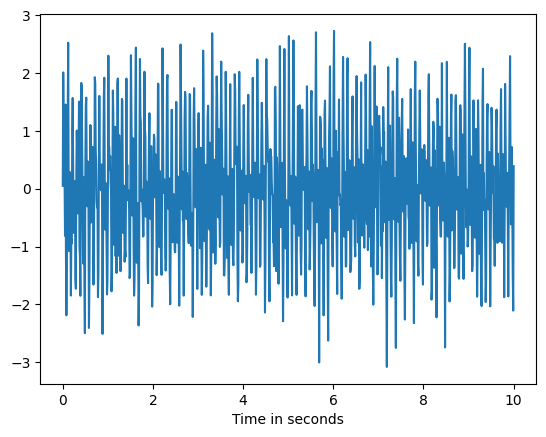

In [16]:
freq1=10
freq2=20
sampling_rate=100
sigma=0.5
[T,signal]=generateSumOfNoisySinusoids(2,[freq1,freq2],[1,1],[0,0],sigma,sampling_rate,10)
plt.xlabel('Time in seconds')
plt.plot(T,signal)

In [17]:

def display_Periodograms(signal,freq1,freq2,sigma,sampling_rate):
    N=len(signal)
    L=int(np.sqrt(N))
    M=N//L
    K=M
    S=N//M
    w=np.hamming(M)

    N_FFT=1024
    bins=list(range(N_FFT//2))

    periodo=np.array([periodogram(signal,N_FFT,k,'standard') for k in bins])
    periodo=periodo/np.linalg.norm(periodo)
    periodo_bartlett=np.array([periodogram(signal,N_FFT,k,'bartlett',L=L) for k in bins])
    periodo_bartlett=periodo_bartlett/np.linalg.norm(periodo_bartlett)
    periodo_welch=np.array([periodogram(signal,N_FFT,k,'welch',L=L,K=K,S=S,w=w) for k in bins])
    periodo_welch=periodo_welch/np.linalg.norm(periodo_welch)

    freq=np.array(bins)*sampling_rate//N_FFT

    dirac_freq1=np.zeros(N_FFT//2)
    bin1=int(freq1*N_FFT//sampling_rate)

    dirac_freq1[bin1]=1
    dirac_freq2=np.zeros(N_FFT//2)
    bin2=int(freq2*N_FFT//sampling_rate)
    dirac_freq2[bin2]=1
    var_array=np.array([sigma**2]*(N_FFT//2))
    plt.plot(freq,dirac_freq1,label="f1")
    plt.plot(freq,dirac_freq2,label='f2')
    plt.plot(freq,periodo,label='periodogram standard')
    plt.plot(freq,var_array,label='sigma^2')
    plt.xlabel('Freq (Hz)')
    plt.legend()
    plt.show()

    plt.plot(freq,dirac_freq1,label="f1")
    plt.plot(freq,dirac_freq2,label='f2')
    plt.plot(freq,periodo_bartlett,label='periodogram bartlett')
    plt.plot(freq,var_array,label='sigma^2')
    plt.xlabel('Freq (Hz)')
    plt.legend()
    plt.show()
   
    plt.plot(freq,dirac_freq1,label="f1")
    plt.plot(freq,dirac_freq2,label='f2')
    plt.plot(freq,periodo_welch,label='periodogram welch')
    plt.plot(freq,var_array,label='sigma^2')
    plt.xlabel('Freq (Hz)')
    plt.legend()
    plt.show()


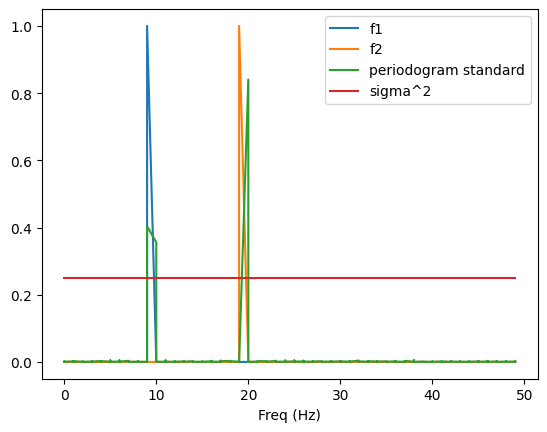

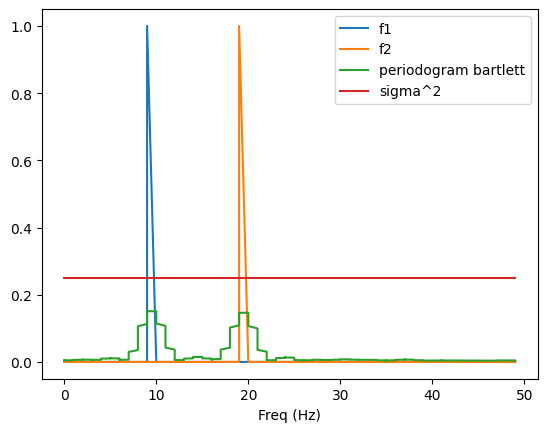

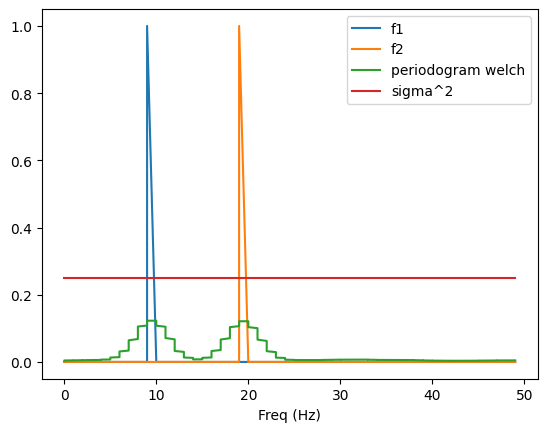

In [18]:
display_Periodograms(signal,freq1,freq2,sigma,sampling_rate)

3.

Text(0.5, 0, 'Time in seconds')

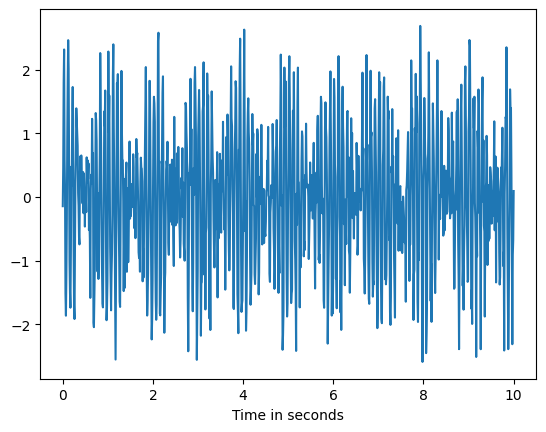

In [19]:
freq1=10
freq2=11
sampling_rate=100
sigma=0.5
[T,signal]=generateSumOfNoisySinusoids(2,[freq1,freq2],[1,1],[0,0],sigma,sampling_rate,10)
plt.plot(T,signal)
plt.xlabel('Time in seconds')

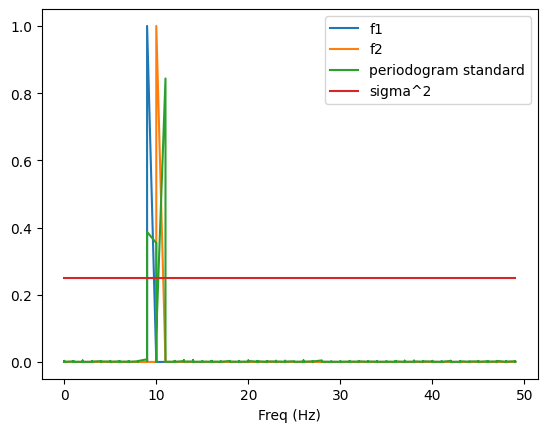

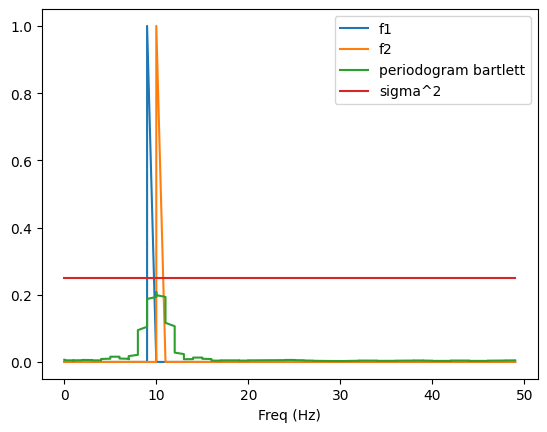

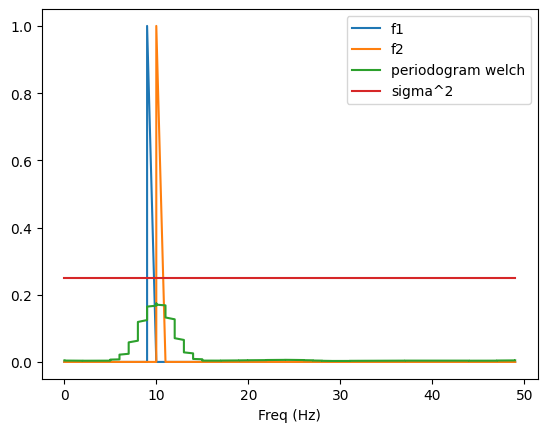

In [20]:
display_Periodograms(signal,freq1,freq2,sigma,sampling_rate)


We observe that for f1=10Hz and f2=11Hz (=> f2-f1=1Hz) the standard periodogram has two peaks near 10 Hz but the Bartlett and the Welch periodograms only have one. We can see the resolution of the standard periodogram is better than Bartlett who is better than Welch.

Text(0.5, 0, 'Time in seconds')

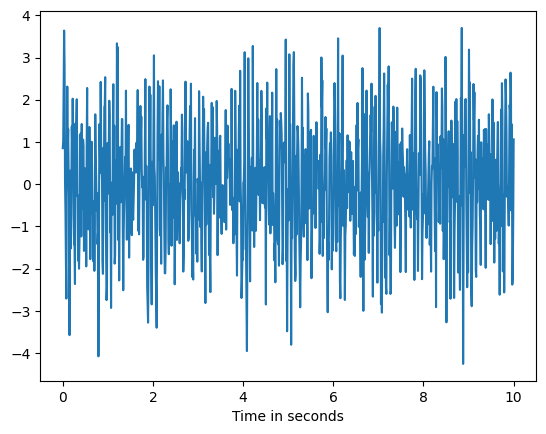

In [21]:
freq1=10
freq2=11
sampling_rate=100
sigma=1
[T,signal]=generateSumOfNoisySinusoids(2,[freq1,freq2],[1,1],[0,0],sigma,sampling_rate,10)
plt.plot(T,signal)
plt.xlabel('Time in seconds')

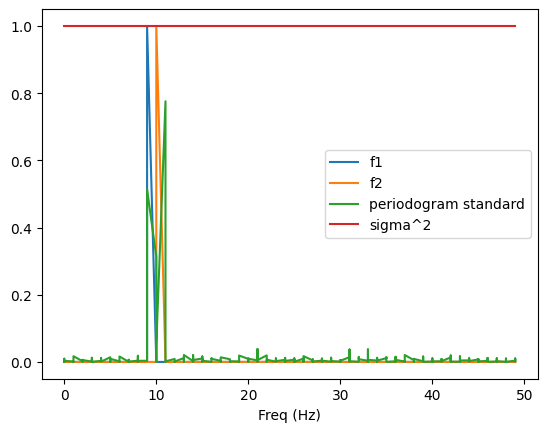

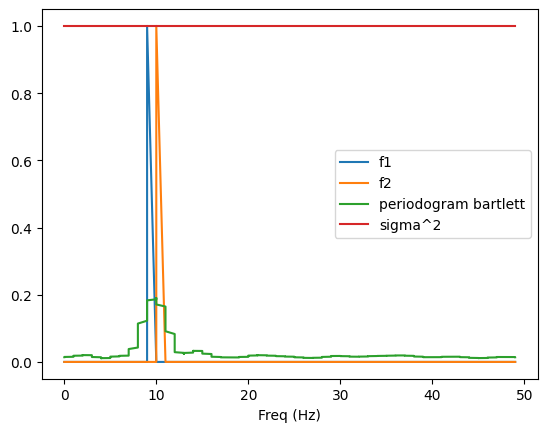

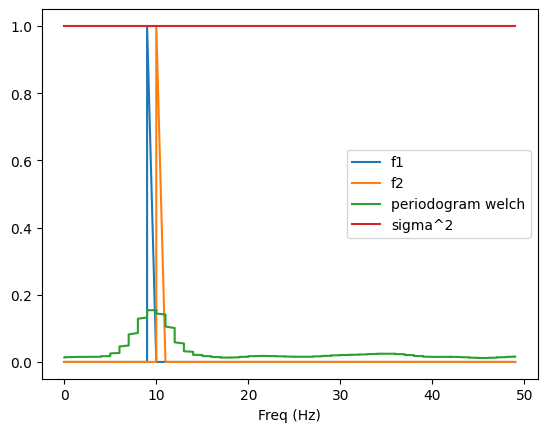

In [22]:
display_Periodograms(signal,freq1,freq2,sigma,sampling_rate)

We observe when we increase the signal-to-noise ratio (we increase sigma) some noise with the standard periodogram. This noise is less significant when we observe the bartlett periodogram. The noise has nearly completely disappeared for the Welch periodogram.

***2.3 Parametric estimation***

4.


In [23]:

def display_Periodograms(signal,freq1,freq2,sigma,sampling_rate):
    N=len(signal)
    L=int(np.sqrt(N))
    M=N//L
    K=M
    S=N//M
    w=np.hamming(M)

    N_FFT=1024
    bins=list(range(N_FFT//2))

    periodo=np.array([periodogram(signal,N_FFT,k,'standard') for k in bins])
    periodo=periodo/np.linalg.norm(periodo)
    periodo_bartlett=np.array([periodogram(signal,N_FFT,k,'bartlett',L=L) for k in bins])
    periodo_bartlett=periodo_bartlett/np.linalg.norm(periodo_bartlett)
    periodo_welch=np.array([periodogram(signal,N_FFT,k,'welch',L=L,K=K,S=S,w=w) for k in bins])
    periodo_welch=periodo_welch/np.linalg.norm(periodo_welch)

    p=4
    gamma=generateGamma(signal,p)
    result =np.matmul(np.linalg.inv(gamma),np.transpose(np.array([1]+[0]*p)))
    var= 1/result[0]
    result = result*var*(-1)
    result=[round(r,2) for r in result]
    
    PSD=np.array([theoreticalSpecPower(N_FFT,k,result[1:],np.sqrt(var)) for k in bins])
    PSD=PSD/np.linalg.norm(PSD)




    freq=np.array(bins)*sampling_rate//N_FFT

    dirac_freq1=np.zeros(N_FFT//2)
    bin1=int(freq1*N_FFT//sampling_rate)

    dirac_freq1[bin1]=1
    dirac_freq2=np.zeros(N_FFT//2)
    bin2=int(freq2*N_FFT//sampling_rate)
    dirac_freq2[bin2]=1
    var_array=np.array([sigma**2]*(N_FFT//2))
    plt.plot(freq,dirac_freq1,label="f1")
    plt.plot(freq,dirac_freq2,label='f2')
    plt.plot(freq,periodo,label='periodogram standard')
    plt.plot(freq,PSD,label='PSD estimated AR')
    
    plt.plot(freq,var_array,label='sigma^2')
    plt.xlabel('Freq (Hz)')
    plt.legend()
    plt.show()

    plt.plot(freq,dirac_freq1,label="f1")
    plt.plot(freq,dirac_freq2,label='f2')
    plt.plot(freq,periodo_bartlett,label='periodogram bartlett')
    plt.plot(freq,PSD,label='PSD estimated AR')
    
    plt.plot(freq,var_array,label='sigma^2')
    plt.xlabel('Freq (Hz)')
    plt.legend()
    plt.show()
   
    plt.plot(freq,dirac_freq1,label="f1")
    plt.plot(freq,dirac_freq2,label='f2')
    plt.plot(freq,periodo_welch,label='periodogram welch')
    plt.plot(freq,PSD,label='PSD estimated AR')
    
    plt.plot(freq,var_array,label='sigma^2')
    plt.xlabel('Freq (Hz)')
    plt.legend()
    plt.show()


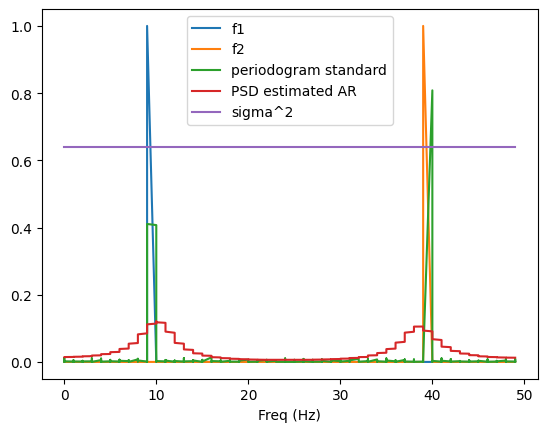

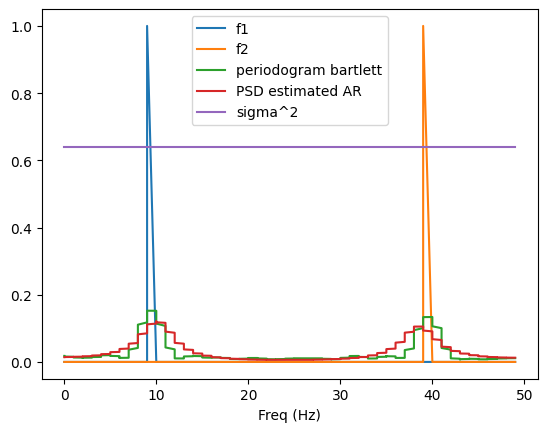

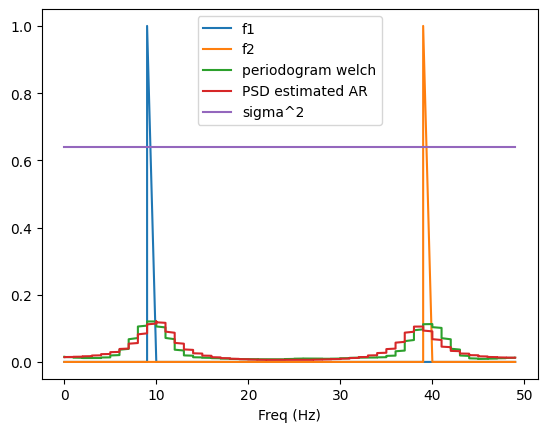

In [24]:
freq1=10
freq2=40
sampling_rate=100
sigma=0.8

[T,signal]=generateSumOfNoisySinusoids(2,[freq1,freq2],[1,1],[0,0],sigma,sampling_rate,10)
display_Periodograms(signal,freq1,freq2,sigma,sampling_rate)

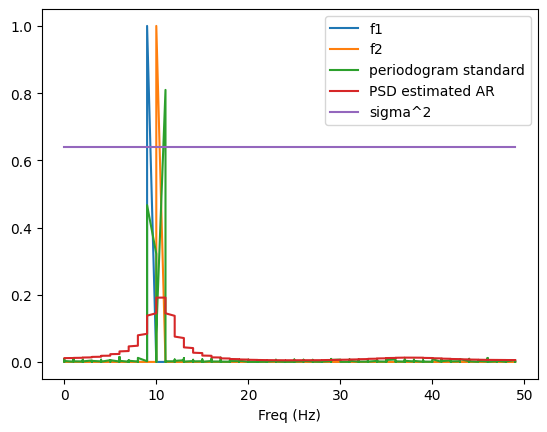

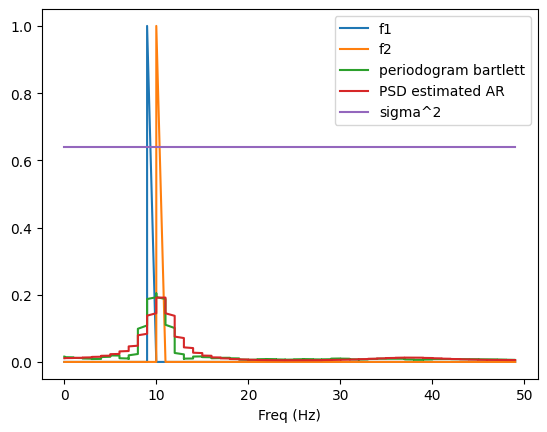

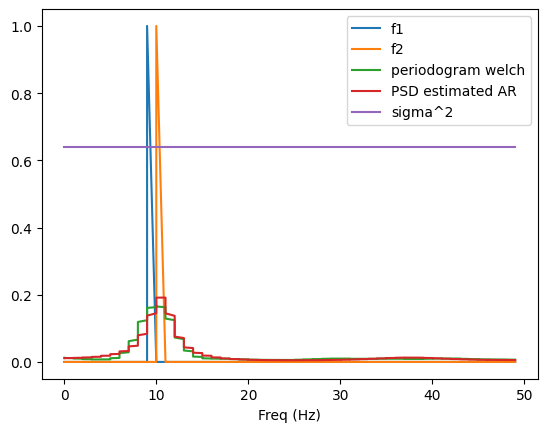

In [25]:
freq1=10
freq2=11
sampling_rate=100
sigma=0.8

[T,signal]=generateSumOfNoisySinusoids(2,[freq1,freq2],[1,1],[0,0],sigma,sampling_rate,10)
display_Periodograms(signal,freq1,freq2,sigma,sampling_rate)

The resolution of the PSD of the estimated AR model is less than the resolution of the periodogram of the exact signal.

***2.4 Capon estimator***

6.

In [26]:
def Capon_estimator(Rxx_inv,N,N_FFT,k):
    
    j=complex(0,1)
    nu=k/N_FFT
    e_nu=np.array([np.exp(2*np.pi*nu*j*n) for n in range(N)])
    
    capon=N/(np.conjugate(e_nu).T@Rxx_inv@e_nu)
    return capon

Done


C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


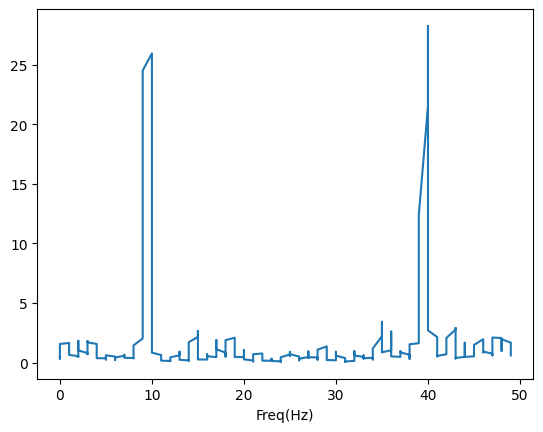

In [27]:
freq1=10
freq2=40
sampling_rate=100
sigma=0.8
N_FFT=1024
[T,signal]=generateSumOfNoisySinusoids(2,[freq1,freq2],[1,1],[0,0],sigma,sampling_rate,2)
N=len(signal)
Rxx=generateGamma(signal,N-1)
Rxx_inv=np.linalg.inv(Rxx)
print("Done")
bins=list(range(N_FFT//2))
freq=np.array(bins)*sampling_rate//N_FFT
cap=np.array([Capon_estimator(Rxx_inv,N,N_FFT,k) for k in bins])
plt.xlabel('Freq(Hz)')
plt.plot(freq,cap)

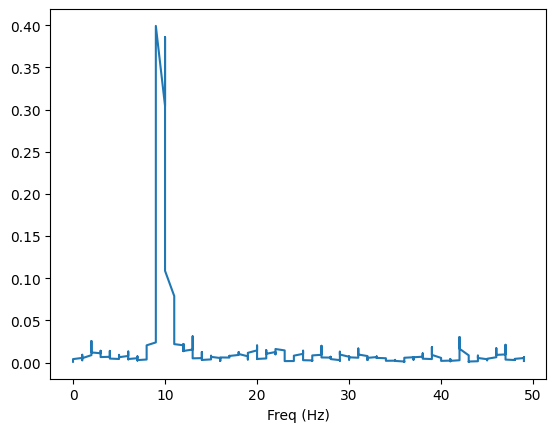

In [28]:
freq1=10
freq2=10.5
sampling_rate=100
sigma=0.8
N_FFT=1024
[T,signal]=generateSumOfNoisySinusoids(2,[freq1,freq2],[1,1],[0,0],sigma,sampling_rate,2)
N=len(signal)
Rxx=generateGamma(signal,N-1)
Rxx_inv=np.linalg.inv(Rxx)

bins=list(range(N_FFT//2))
freq=np.array(bins)*sampling_rate//N_FFT
cap=np.array([Capon_estimator(Rxx_inv,N,N_FFT,k) for k in bins])
cap=cap/np.linalg.norm(cap)
plt.xlabel('Freq (Hz)')
plt.plot(freq,cap,label='capon estimator')


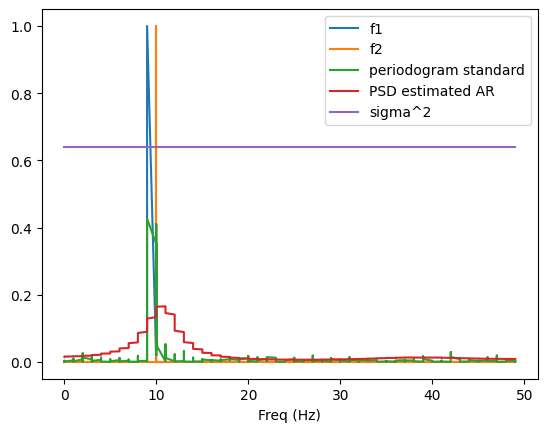

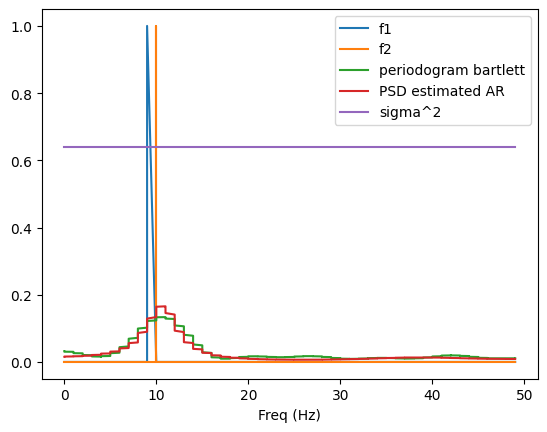

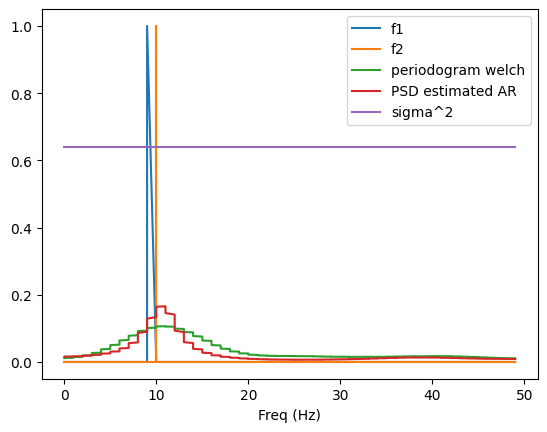

In [29]:
display_Periodograms(signal,freq1,freq2,sigma,sampling_rate)

 its resolution is slightly less than the standard periodogram.

***3 Autoregressive-moving-average process***

***3.1 Synthesis***

In [30]:
def generateARMA(N,AR_coeff,MA_coeff,sigma):
    AR_coeff=[1]+AR_coeff
    MA_coeff=[1]+MA_coeff
    Z= np.random.normal(0,sigma,N)
    X=Z
    for t in range(1,N):
        for i in range(1,len(AR_coeff)):
            if t-i>=0:
                X[t]+=AR_coeff[i]*X[t-i]
        for j in range(1,len(MA_coeff)):
            if t-j>=0:
                X[t]+=MA_coeff[j]*Z[t-j]
    return X

***3.2 Non parametric estimation : periodogram***

2. 

In [31]:
def PSD_ARMA(N_FFT,AR_coeff,MA_coeff,sigma,k):
    """_summary_

    Args:
        N_FFT (_type_): resolution of FFT
        AR_coeff (_type_): AR coefficients
        MA_coeff (_type_): MA coefficients
        sigma (_type_): innovation standard deviation
        k (_type_): bin FFT index

    Returns:
        PSD(k/N_FFT): PSD value at reduced frequency k/N_FFT
    """
    
    num=1
    j=complex(0,1)
    MA_coeff=[1]+MA_coeff
    AR_coeff=[1]+AR_coeff
    for n in range(1,len(MA_coeff)):
        num+=MA_coeff[n]*np.exp(-2*j*np.pi*(k/N_FFT)*n)
    num=(sigma**2) * np.absolute(num)**2
    denom=1
    for n in range(1,len(AR_coeff)):
        denom-=AR_coeff[n]*np.exp(-2*j*np.pi*(k/N_FFT)*n)
    denom=np.absolute(denom)**2
    PSD=num/denom


    return PSD


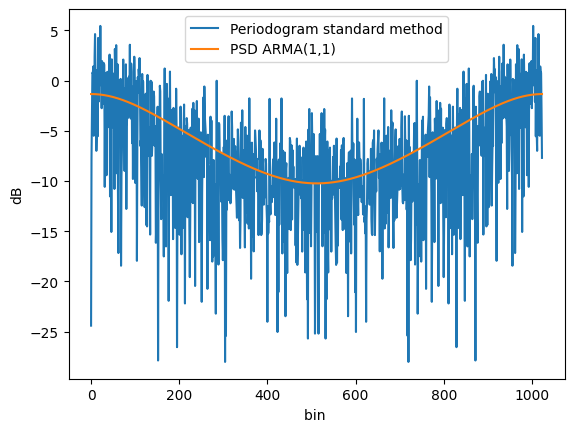

In [32]:
N_FFT=1024
N=1000
X=generateARMA(N,[0.3],[0.2],0.5)
bins_std=list(range(N_FFT))


Periodos_std=np.array([periodogram(X,N_FFT,k,'standard') for k in bins_std])


PSD=np.array([PSD_ARMA(N_FFT,[0.3],[0.2],0.5,k) for k in bins_std])

plt.xlabel("bin ")
plt.ylabel('dB')
plt.plot(bins_std,10*np.log10(Periodos_std),label="Periodogram standard method")

plt.plot(bins_std,10*np.log10(PSD),label="PSD ARMA(1,1)")
plt.legend()
plt.show()

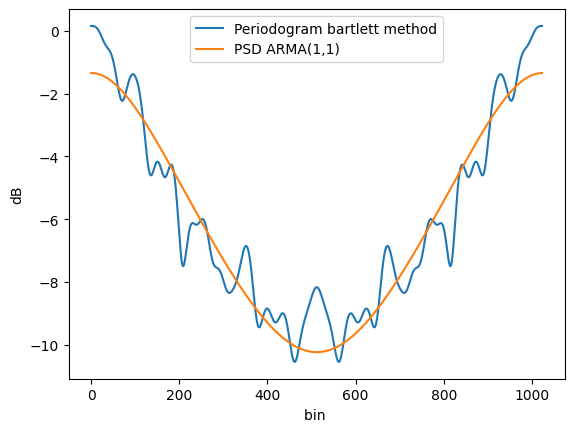

In [33]:
L=int(np.sqrt(N))

Periodos_bartlett=np.array([periodogram(X,N_FFT,k,'bartlett',L) for k in bins_std])

plt.xlabel("bin ")
plt.ylabel('dB')
plt.plot(bins_std,10*np.log10(Periodos_bartlett),label="Periodogram bartlett method")

plt.plot(bins_std,10*np.log10(PSD),label="PSD ARMA(1,1)")
plt.legend()
plt.show()

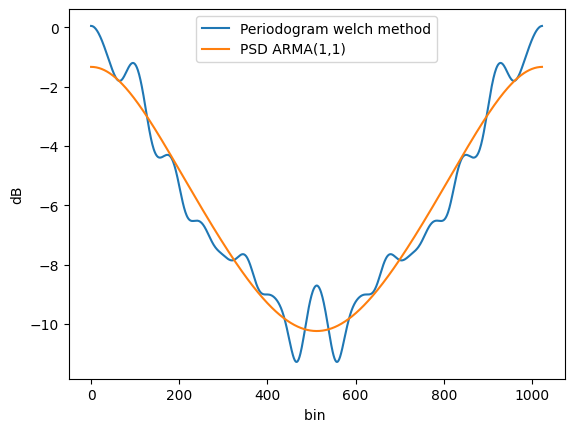

In [34]:
L=int(np.sqrt(N))
M=N//L
K=M
S=N//M
w=np.hamming(M)

Periodos_welch=np.array([periodogram(X,N_FFT,k,method='welch',L=L,K=K,S=S,w=w) for k in bins_std])

plt.xlabel("bin ")
plt.ylabel('dB')
plt.plot(bins_std,10*np.log10(Periodos_welch),label="Periodogram welch method")

plt.plot(bins_std,10*np.log10(PSD),label="PSD ARMA(1,1)")
plt.legend()
plt.show()

3. The three estimators satisfy the property of asymptotic unbiasedness.  
The Bartlett estimator has less variance than the standard estimator.  
The Welch estimator has even less variance than the Bartlett estimator. 


***3.3 Parametric estimation : Durbin method***

4.

In [35]:
def Durbin(X,p,q,L):
    #estimation of the AR part
    gamma_mod=np.zeros((p,p))
    for i in range(0,p):
        for j in range(0,p):
            gamma_mod[i][j]=empiricalAutoCov(X,np.abs(q+i-j))
    
    v=np.array([empiricalAutoCov(X,q+m) for m in range(1,p+1)])
    AR_coeff=scipy.linalg.pinv(gamma_mod)@np.transpose(v)
    #estimation of the MA part

    
    Y=X
    coeff=[1]+AR_coeff
    for t in range(1,len(X)):
        for i in range(1,len(coeff)):
            if t-i>=0:
                Y[t]-=coeff[i]*X[t-i]
    
    
    gamma=generateGamma(Y,  L)
    result =np.matmul(scipy.linalg.pinv(gamma),np.array([1]+[0]*L))
    var1= 1/result[0]
    result = result*var1
    result = result*(-1)
    sigma_1=np.sqrt(var1)
    a_hat=result[1:]
    
    A_L_hat=1-np.fft.fft(np.array([0]+a_hat))

    u_L_hat=np.fft.ifft(np.absolute(A_L_hat)**2,2*L+1)
    u_L_hat=np.real(u_L_hat)
    
    u_L_hat=u_L_hat[:L+1]
    r_L_matrix = np.zeros((q+1,q+1))
    for i in range(q+1):
        for j in range(q+1):
            r_L_matrix[i][j]=u_L_hat[i-j]
    

    res =np.matmul(scipy.linalg.pinv(r_L_matrix),np.array([1]+[0]*q))
    
    var2= np.absolute(1/res[0])
    res = res*var2
    res = res*(-1)
    sigma_2=np.sqrt(var2)
    b_hat=res[1:]
    

    sigma_Z=sigma_1/sigma_2
    return sigma_Z,AR_coeff,b_hat



5.

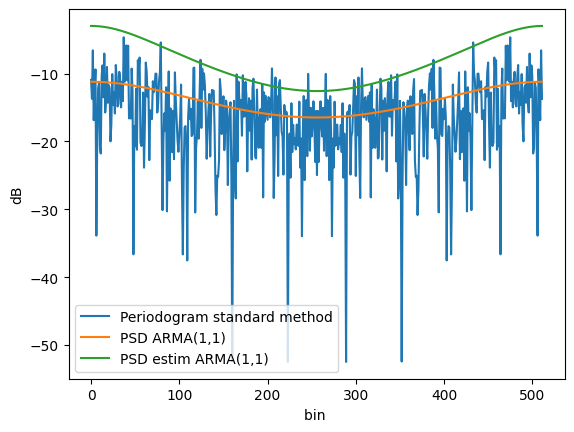

In [36]:
N_FFT=512
N=500
X=generateARMA(N,[0.2],[0.1],0.2)
bins_std=list(range(N_FFT))


Periodos_std=np.array([periodogram(X,N_FFT,k,'standard') for k in bins_std])

sigma_Z,AR_coeff,b_hat=Durbin(X,1,1,10)

PSD=np.array([PSD_ARMA(N_FFT,[0.2],[0.1],0.2,k) for k in bins_std])
PSD_estim=np.array([PSD_ARMA(N_FFT,[AR_coeff],[b_hat],sigma_Z,k) for k in bins_std])
plt.xlabel("bin ")
plt.ylabel('dB')
plt.plot(bins_std,10*np.log10(Periodos_std),label="Periodogram standard method")

plt.plot(bins_std,10*np.log10(PSD),label="PSD ARMA(1,1)")
plt.plot(bins_std,10*np.log10(PSD_estim),label="PSD estim ARMA(1,1)")
plt.legend()
plt.show()

The periodogram is oscillating around the spectral envelope of the exact ARMA model. There is a small offset between the spectral envelope of the estimated ARMA model and of the exact AEMA model due to the estimation error. 

***3.4 Application to speech signals***

6. 

In [37]:
aud= librosa.load('sounds//an_in_on.wav',sr=8000)[0]


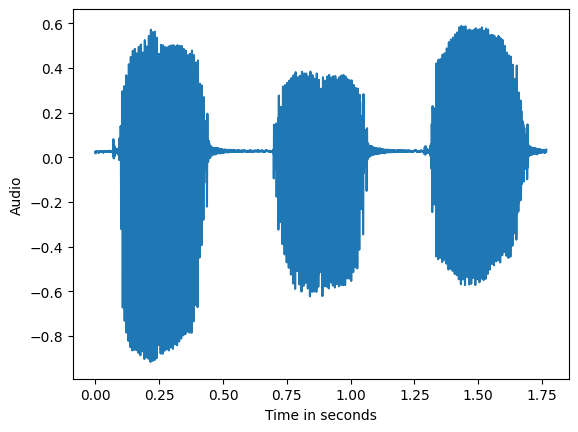

In [38]:
sr=8000
sample_time = np.linspace(0, len(aud)/sr, len(aud))
plt.plot(sample_time,aud)
plt.xlabel('Time in seconds')
plt.ylabel('Audio')
plt.show()

start=int(0.2*sr)
stop=int(0.3*sr)
an_sound=aud[start:stop]
an_sound=an_sound[~np.isnan(an_sound)]


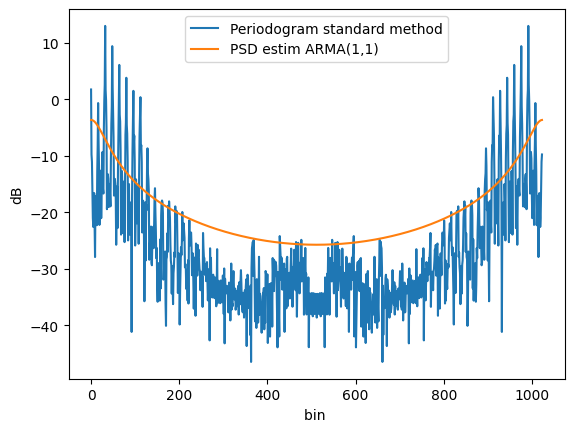

In [39]:
an_sound_copy=np.copy(an_sound)

p=1
q=1
N_FFT=1024


bins=list(range(N_FFT))
sigma_Z,AR_coeff,b_hat=Durbin(an_sound_copy,p,q,10*q)

Periodos_std=np.array([periodogram(an_sound_copy,N_FFT,k,'standard') for k in bins])

PSD_estim=np.array([PSD_ARMA(N_FFT,[AR_coeff],[b_hat],sigma_Z,k) for k in bins])

plt.xlabel("bin ")
plt.ylabel('dB')
plt.plot(bins,10*np.log10(Periodos_std),label="Periodogram standard method")


plt.plot(bins,10*np.log10(PSD_estim),label="PSD estim ARMA(1,1)")
plt.legend()
plt.show()


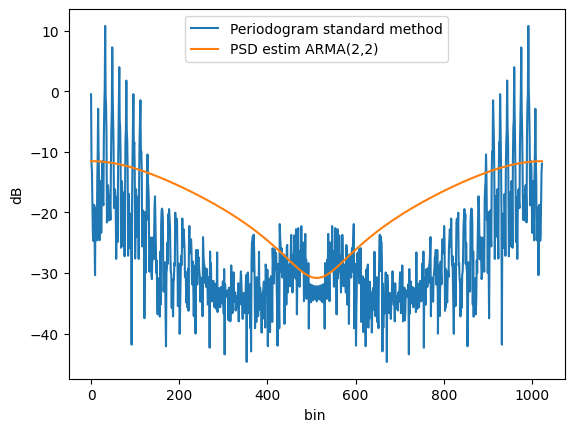

In [41]:
an_sound_copy=np.copy(an_sound)

p=2
q=2
N_FFT=1024


bins=list(range(N_FFT))
sigma_Z,AR_coeff,b_hat=Durbin(an_sound_copy,p,q,10*q)

Periodos_std=np.array([periodogram(an_sound_copy,N_FFT,k,'standard') for k in bins])

PSD_estim=np.array([PSD_ARMA(N_FFT,AR_coeff,b_hat,sigma_Z,k) for k in bins])

plt.xlabel("bin ")
plt.ylabel('dB')
plt.plot(bins,10*np.log10(Periodos_std),label="Periodogram standard method")


plt.plot(bins,10*np.log10(PSD_estim),label="PSD estim ARMA(2,2)")
plt.legend()
plt.show()